To Find Visually Similar Images as the Query Image

In [1]:
# Import Packages
import os
import gdown
import pickle
import zipfile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

class vizSim:
  def __init__(self, model = InceptionV3(), target_size = (299, 299)):
    # vectors and inv_vectors are maps to store images' paths and vector representations
    self.vectors = {}        # path as key and vector as value
    self.inv_vectors = {}    # vector as key and path as value
    self.model = model       # Pre trained model to be used
    self.target_size = target_size # Image size compatible with the pretrained model's input layer
  
  def getData(self, url, q = False):
    # Download the database
    gdown.download(url, fuzzy = True, quiet = q)
    # Unzip it
    with zipfile.ZipFile('visualsimilarity.zip', 'r') as zip_ref:
      zip_ref.extractall()
    # Remove the zipped file
    os.remove('visualsimilarity.zip')
  
  def encode(self):
    # Remove the output dense layer for the pretrained model
    model = Model(inputs = self.model.inputs, outputs = self.model.layers[-2].output)
    # Set of paths of images in the database
    files = set([os.path.join('bottoms_resized_png/', f) for f in os.listdir('bottoms_resized_png/')])
    # for every image preprocessing and feature extraction is done
    for path in tqdm(files - self.vectors.keys()):      # In case the image's represenation already exist, it is removed (For reproducability when the database is updated)
      img = load_img(path, target_size = self.target_size)    # Loading and resizing image
      # Preprocessing
      img = img_to_array(img)
      img = np.expand_dims(img, axis = 0)
      img = preprocess_input(img)
      vector = model.predict(img)[0]                    # Extracting features
      # Storing features
      self.vectors[path] = vector
      self.inv_vectors[tuple(vector)] = path
  
  def save(self, path = 'embeddings.pickle'):
    # Save variables
    with open(path, 'wb') as pkl:
      pickle.dump((self.vectors, self.inv_vectors), pkl)
  
  def load(self, path = 'embeddings.pickle'):
    # Load Variables
    with open(path, 'rb') as pkl:
      (self.vectors, self.inv_vectors) = pickle.load(pkl)
  
  def similar(self, test, num = 10):
    # Find images similar to the query image
    # Extract features from the query image
    model = Model(inputs = self.model.inputs, outputs = self.model.layers[-2].output)
    img = load_img(test, target_size = self.target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    enc_test = model.predict(img)
    # Calculate cosine similarity with all the images in the database and pick 'num' images with the highest similarity score
    values = list(self.vectors.values())
    ind = np.argpartition(cosine_similarity(enc_test, values)[0], -num)[-num:]
    # Return the file names for the visually similar images
    return [self.inv_vectors[tuple(values[i])] for i in ind]
  
  def display(self, test, ind):
    # Display the query image
    img = mpimg.imread(test)
    plt.axis('off')
    plt.title('Input Garment')
    plt.imshow(img)
    # Display the similar images found
    plt.show()
    _, axs = plt.subplots(len(ind)//5, 5, figsize = (12, 8))
    axs = axs.flatten()
    plt.suptitle('Similar Garments')
    for img, ax in zip(ind, axs):
      ax.axis('off')
      ax.imshow(mpimg.imread(img))
    plt.show()

Populating the interactive namespace from numpy and matplotlib
96124928/96112376 [==============================] - 1s 0us/step


Downloading...
From: https://drive.google.com/uc?id=1OCvfi5L_znC3xGGyH_hXEYEKSGcRleHU
To: /content/visualsimilarity.zip
100%|██████████| 72.2M/72.2M [00:00<00:00, 146MB/s]
100%|██████████| 1050/1050 [05:12<00:00,  3.36it/s]


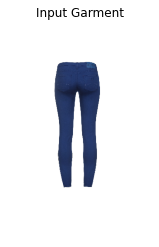

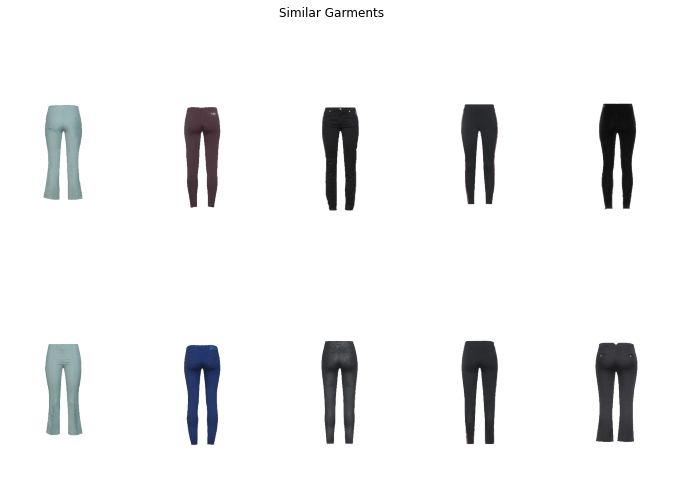

In [2]:
# drive link for the database of images
url = 'https://drive.google.com/file/d/1OCvfi5L_znC3xGGyH_hXEYEKSGcRleHU/view?usp=sharing'
# Path of Query Image
test = 'bottoms_resized_png/13079565VVD.png'

identifier = vizSim()             # Create an instance
identifier.getData(url)           # Download, Extract and Remove the zipped file
identifier.encode()               # Extract Features from the data to form a vector representation
identifier.save()                 # Save the vector representation as a pickle file

ind = identifier.similar(test)    # Get paths for the images visually similar to the Query Image
identifier.display(test, ind)     # Display the Query Image along with the Similar Images

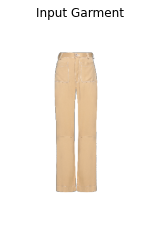

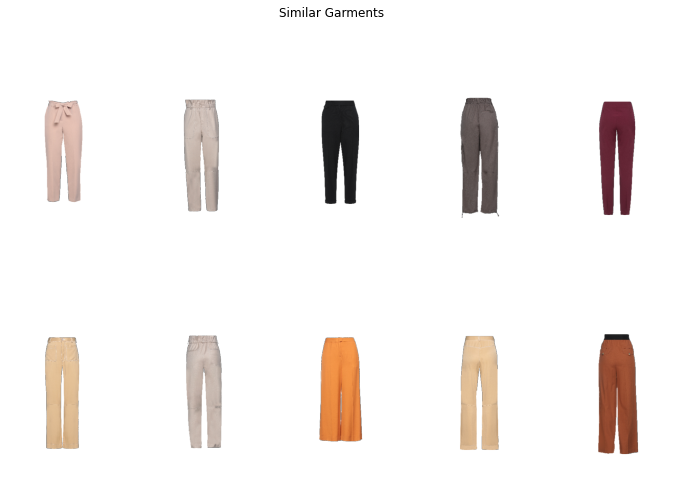

In [3]:
# For running another query with existing vector representation
test = 'bottoms_resized_png/13425393LGR.png'
identifier = vizSim()
identifier.load()                 # Load the vector representation from the pickle file saved earlier
ind = identifier.similar(test)
identifier.display(test, ind)